In [1]:
# ---------CASO D.2: Loop ideal V cte y empuje no cte -----------
import numpy as np
import pysindy as ps
from scipy.integrate import odeint, solve_ivp
#import eprint

import matplotlib.pyplot as plt
import math

import utils
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from mpl_toolkits.mplot3d import Axes3D

## Ecuaciones

- Para este caso se asume que la variación en la altura es tan pequeña que apenas produce cambio en la densidad
- Al tratarse de un loop ideal, el movimiento es simétrico en el plano vertical y se desarrollará con las alas a nivel
- Hay 3 ecuaciones (2 dinámicas y una angular) y 3 incógnitas (T, alpha y gamma)
$$
L - W\cos{\gamma} = mV_0\dot{\gamma}\\
\frac{1}{2} \rho_{aire} V^{2} S C_{L} - W\cos{\gamma} = mV_0\dot{\gamma}\\
---\\
T - D - W\sin{\gamma} = m\dot{V} = 0\\
T - (C_{D0} + kC_{L}^2)\frac{1}{2} \rho_{aire} V_0^{2}S - W\sin{\gamma} = 0\\
T = (C_{D0} + kC_{L}^2)\frac{1}{2} \rho_{aire} V_0^{2}S + W\sin{\gamma}\\
---\\
\dot{\gamma} = \frac{V_0}{R}

$$

- Debido a la complejidad de este caso se usará las variables Cl, V y gamma. Alpha se considera dependendiente del cl, si no hay demasiados términos y sindy no es capaz de calcularlo

- Se despeja el cl de la primera ecuación:

$$
C_L = \frac{2}{\rho S V_0^2}(W \cos{\gamma} + m \frac{V_0^2}{R})\\
$$

Se sustituye en la segunda ecuación:
$$
T = \frac{1}{2} S\rho_{aire} V_0^{2}C_{D0} + \frac{2k}{S\rho_{aire} V_0^{2}} (W^2 (\cos{\gamma})^2 + m^2\frac{V_0^4}{R^2} + \frac{2WmV_0^2}{R}\cos{\gamma}) + W\sin{\gamma}\\
\dot{\gamma} = \frac{V_0}{R}
$$

Definiendo:

$$
A_1 = \frac{1}{2} S\rho_{aire} V_0^{2}  \\
A_2 = A_1 C_{D0} \\
A_3 = \frac{k}{A_1} \frac{m^2V_0^4}{R^2} = \frac{2km^2V_0^2}{\rho S R^2} \\
A_4 = \frac{k}{A_1} W^2 = \frac{2kW^2}{\rho S V_0^2} \\
A_5 = \frac{k}{A_1} \frac{2WmV_0^2}{R} = \frac{4kWm}{\rho S R} \\
A_6 = \frac{V_0}{R} \\
A_7 = A_2 + A_3

$$

Por tanto, las ecuaciones son las siguientes:

$$
T = A_7  + A_4(\cos{\gamma})^2 + A_5\cos{\gamma} + W\sin{\gamma}  \\
\dot{\gamma} = A_6 
$$

Sindy debe obtener las siguientes ecuaciones en derivadas:
$$
\dot{T} = -2A_4\frac{V_0}{R}\cos{\gamma}\sin{\gamma} - A_5\frac{V_0}{R}\sin{\gamma} + W\frac{V_0}{R}\cos{\gamma} \\
\dot{T} = -A_4\frac{V_0}{R}\sin{2\gamma} - A_5\frac{V_0}{R}\sin{\gamma} + W\frac{V_0}{R}\cos{\gamma} \\
\dot{\gamma} = A_6 
$$

Si se define:
$$
A_6 = \frac{V_0}{R} \\
A_8 = A_4\frac{V_0}{R} \\
A_9 = A_5\frac{V_0}{R} \\
A_{10} = W\frac{V_0}{R}
$$
Sindy debe predecir:
$$
\dot{T} = -A_8\sin{2\gamma} - A_9\sin{\gamma} + A_{10}\cos{\gamma} \\
\dot{\gamma} = A_6 
$$

## Variables globales

In [2]:
#definición de las variables generales
n = 10000
deltat = 0.001
""" t = np.zeros(n+1)
for i in range(1, n+1):
    t[i] = deltat*i

print(t.shape[0], t) """
t = np.arange(0, int(n*deltat), deltat)
N_SIMS = 15


In [3]:
# definicion de parametros fisicos y aerodinamicos de la aeronave
m = 100
W = m*9.81
vx0 = 10
S = 14.7
cd0 = 0.03
k = 0.073

V0 = 10
R = 100
# velocidad caracteristica
U = (2*9.81*m/(1.225*S))**0.5
Tc = U/9.81
A1 = 0.5*1.225*S*V0**2
A2 = A1*cd0
A3 = (k*m**2 * V0**4)/(A1*R**2)
A4 = k*W**2/A1
A5 = (2*k*W*m*V0**2)/(R*A1)
A6 = V0/R*10
A7 = A2 + A3
A8 = A4*V0/R
A9 = A5*V0/R
A10 = W*V0/R
print(f"Valor de los coeficientes: A4={A4}, A5={A5}, A6={A6}, A7={A7}, W={W}")
print(f"Coeficientes que sindy debe calcular: A6={A6}, A8={A8}, A9={A9}, A10={A10}")



Valor de los coeficientes: A4=78.02565930862141, A5=15.907371928363181, A6=1.0, A7=27.8220232889074, W=981.0
Coeficientes que sindy debe calcular: A6=1.0, A8=7.802565930862142, A9=1.590737192836318, A10=98.1


In [4]:
def initial_vars(lib):
    data = [np.ones((n, 2)), np.ones((n, 2))]
    print(data[0].shape, data[0].reshape(-1, 1).shape)
    lib = utils.custom_ecs_D2().fit(data[0])
    n_features = lib.n_output_features_
    list_names = lib.get_feature_names(['T', 'gamma'])
    print(list_names)

    return n_features, data, list_names

In [5]:
# creo un initial guess para que la primera solucion que encuentre no sea la de todas las ecuaciones = 0
#uso un reshape por el caso de tener un array, pues no tiene dimension de columnas, es posicional
def initial(val=10, lib=None):
    if lib is None:
        lib = utils.custom_ecs_D2()
        n_features, data, list_names = initial_vars(lib)
        initial_guess = np.zeros((data[0].shape[1], n_features))

        initial_guess[0, list_names.index('sin(gamma)')] = 1
        initial_guess[0, list_names.index('sin(2*gamma)')] = 1
        initial_guess[0, list_names.index('cos(gamma)')] = 100

        #initial_guess[1, list_names.index('1T')] = 0.1
        #initial_guess[1, list_names.index('1gamma')] = 0.1

        return initial_guess
    else:
        n_features, data, list_names = initial_vars(lib)
        return np.ones((data[0].shape[1], n_features))
        



## Funciones

In [6]:
def plot_ntraj(n_trayec, errors, labs=['nada', 'initial_guess']):
    # lista errors: sin aplicar otro tipo de entrada, con cond inic, con restris y completo 
    fig, axs = plt.subplots(1, 2, figsize=(17, 7))
    #fig.suptitle('Horizontally stacked subplots')
    errors_mean = []
    for err in errors:    
        errors_mean.append(np.mean(err, axis=2))
   
    name = ['Empuje (Newton)', 'Ángulo de asiento de la velocidad (rad)']
    fig.suptitle("Análisis sobre el número de trayectorias", fontsize=18)
    for j, err in enumerate(errors_mean):
        for i in range(err.shape[-1]): 
            axs[i].set_title(name[i], fontsize=16)
            axs[i].semilogy(n_trayec, np.median(err[:, :, i], axis=0), label=labs[j])
            axs[i].set_xlabel('Número de trayectorias', fontsize=16)
            axs[i].set_ylabel('Error cuadrático medio', fontsize=16)
            axs[i].legend(fontsize=12)
            axs[i].tick_params(axis='both', labelsize=14)
        

In [7]:
def plot_error_vs_tiempo(t, errors, trayecs, labs=['nada', 'initial_guess']):
    fig, axs = plt.subplots(1, 2, figsize=(15, 7))
    name = ['Empuje (Newton)', 'gamma (rad)']

    for z, err in enumerate(errors):
        for j in range(err.shape[-1]): 
            axs[j].title.set_text(name[j])
            axs[j].set_xlabel('Tiempo (s)')
            axs[j].set_ylabel('Mediana del error')
            
            err_simp = err[:, :, :, j]
            for i, n in enumerate(trayecs):
                lab = str(n) + ' trayec' + labs[z]
                axs[j].plot(t, np.median(err_simp[:, i], axis=0), label=lab)
            axs[j].legend()


In [8]:
def plot_error_vs_tiempo_val(t, errors, n_trayec, labs=['nada', 'initial_guess']):
    fig, axs = plt.subplots(1, 2, figsize=(15, 7))
    name = ['Empuje (Newton)', 'gamma (rad)']

    for z, err in enumerate(errors):
        for j in range(err.shape[-1]): 
            axs[j].title.set_text(name[j])
            axs[j].set_xlabel('Tiempo de validacion(s)')
            axs[j].set_ylabel('Mediana del error')
            
            err_simp = err[:, :, :, j]
            for i, n in enumerate(n_trayec):
                lab = str(n) + ' trayec' + labs[z]
                axs[j].plot(t, np.median(err_simp[:, i], axis=0), label=lab)
            axs[j].legend()



In [9]:
def plot_error_vs_pot_ruido(error, n_trayec, pots):
    name = ['Empuje (Newton)', 'gamma (rad)']
    fig, axs = plt.subplots(1, 2, figsize=(15, 7))
    fig.suptitle("Evolución error según potencia de ruido", fontsize=18)

    for j in range(error.shape[-1]): 
        axs[j].set_title(name[j], fontsize=16)
        axs[j].set_xlabel('Potencia de ruido', fontsize=14)
        axs[j].set_ylabel('Error cuadrático medio', fontsize=14)
           
        err_simp = error[:, :, :, j]
        for i, n in enumerate(n_trayec):
            lab = str(n) + ' trayec' 
            axs[j].loglog(pots, np.median(err_simp[:, i], axis=0), label=lab)
            #axs[j].semilogx(pots, np.median(err_simp[:, i], axis=0), label=lab)
            axs[j].legend(fontsize=12)
            axs[j].tick_params(axis='both', labelsize=14)

In [10]:
def plot_precision_tiempo(error, muestras, tiempos):
    name = ['vel (m/s)', 'gamma (rad)']
    fig, ax = plt.subplots(1, 2, figsize=(15, 7))
    M, T = np.meshgrid(muestras, tiempos)
    
    for j in range(error.shape[-1]): 
        ax[j].title.set_text(name[j])
        ax[j].set_xlabel('Tiempo máximo de entrenamiento')
        ax[j].set_ylabel('Número de muestras')
        ax[j].set_zlabel('Error cuadrático medio')

        err_simp = error[:, :, :, :, j]
        
        ax[j] = Axes3D(fig)
        ax[j].plot_surface(T, M, np.median(err_simp[:, :, :, i], axis=0))
        ax[j].legend()
    

## Evaluación

T = -7.796 sin(2*gamma) + -1.594 sin(gamma) + 98.085 cos(gamma)
gamma = 1.000 1gamma


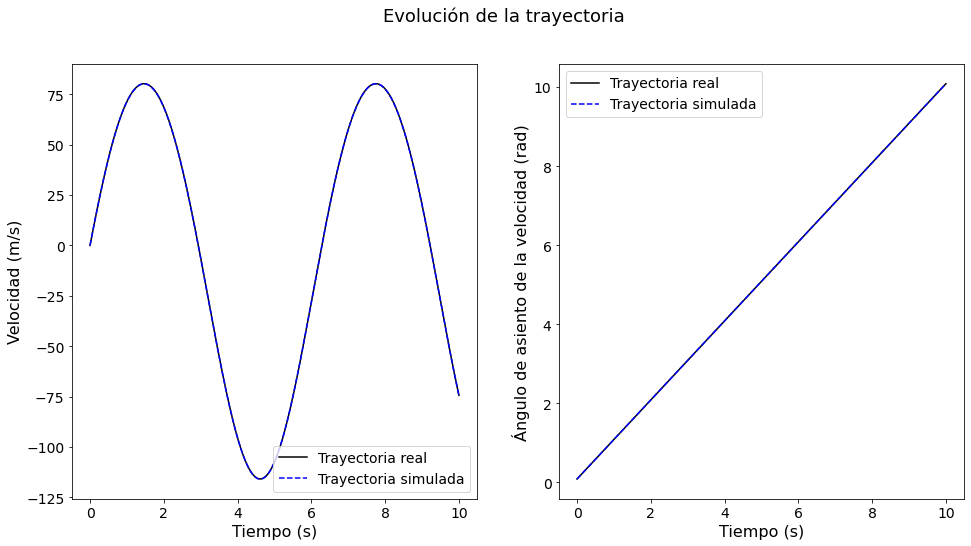

In [14]:
labs=['nada', 'initial_guess']
# con derivadas
n_trayectorias_test = [2, 5, 10, 15]
n_sims = 10#N_SIMS
x0 = [5, 5] #T0 y gamma0 en grados, de validacionn
deltat_train = t[1]-t[0]

t_val = np.arange(0, int(n*deltat_train), deltat_train)
len_traj = t_val.shape[0]
#assert n2 == len_traj

models = [utils.Model_params(feature_list=['T', 'gamma'], lib=utils.custom_ecs_D2())]
errors = []
error = np.zeros((n_sims, len(n_trayectorias_test), n, 2))  

for mod, mod_index in zip(models, range(len(models))):
    error = np.zeros((n_sims, len(n_trayectorias_test), len_traj, 2))  
    for i in range(len(n_trayectorias_test)):
        for j in range(n_sims):
            mod_class = utils.Model()
            mod_class.eval(utils.casoD2, n_trayectorias_test[i], t, 
                                        [A6, A8, A9, A10], x0, print_model=False,
                                        adim=False, deltat_train=deltat_train, mod=mod, t_val=t_val, ders=True)
            error[j,i, :, :] = mod_class.error_trayec(t_val)
        if n_trayectorias_test[i] == 15:
            mod_class.plot_trayec(t)
            model15 = mod_class.model_sindy

    errors.append(error)
    #mod_class.plot_trayec(t_val, labs=['Empuje (Newton)', 'Ángulo de asiento de la velocidad (rad)'])
model15.print(lhs=["T'", "gamma'"])


(10000, 2) (20000, 1)
['sin(2*T)', 'sin(2*gamma)', 'sin(T)', 'sin(gamma)', 'cos(T)', 'cos(gamma)', '1T', '1gamma']
(x0)' = -7.7926 sin(2*x1) + -1.5934 sin(x1) + 98.0927 cos(x1)
(x1)' = 1.0000 1x1
(x0)' = -7.8198 sin(2*x1) + -1.5893 sin(x1) + 98.0834 cos(x1)
(x1)' = 1.0000 1x1
(x0)' = -7.8168 sin(2*x1) + -1.5847 sin(x1) + 98.0843 cos(x1)
(x1)' = 1.0000 1x1
(x0)' = -7.7965 sin(2*x1) + -1.5844 sin(x1) + 98.1029 cos(x1)
(x1)' = 1.0000 1x1
(x0)' = -7.7992 sin(2*x1) + -1.5812 sin(x1) + 98.1011 cos(x1)
(x1)' = 1.0000 1x1
(x0)' = -7.8199 sin(2*x1) + -1.5817 sin(x1) + 98.0930 cos(x1)
(x1)' = 1.0000 1x1
(x0)' = -7.8181 sin(2*x1) + -1.5711 sin(x1) + 98.0881 cos(x1)
(x1)' = 1.0000 1x1
(x0)' = -7.8181 sin(2*x1) + -1.5837 sin(x1) + 98.0850 cos(x1)
(x1)' = 1.0000 1x1
(x0)' = -7.8011 sin(2*x1) + -1.5897 sin(x1) + 98.1020 cos(x1)
(x1)' = 1.0000 1x1
(x0)' = -7.8110 sin(2*x1) + -1.5908 sin(x1) + 98.0828 cos(x1)
(x1)' = 1.0000 1x1
(x0)' = -7.8069 sin(2*x1) + -1.5725 sin(x1) + 98.0955 cos(x1)
(x1)' = 1.000

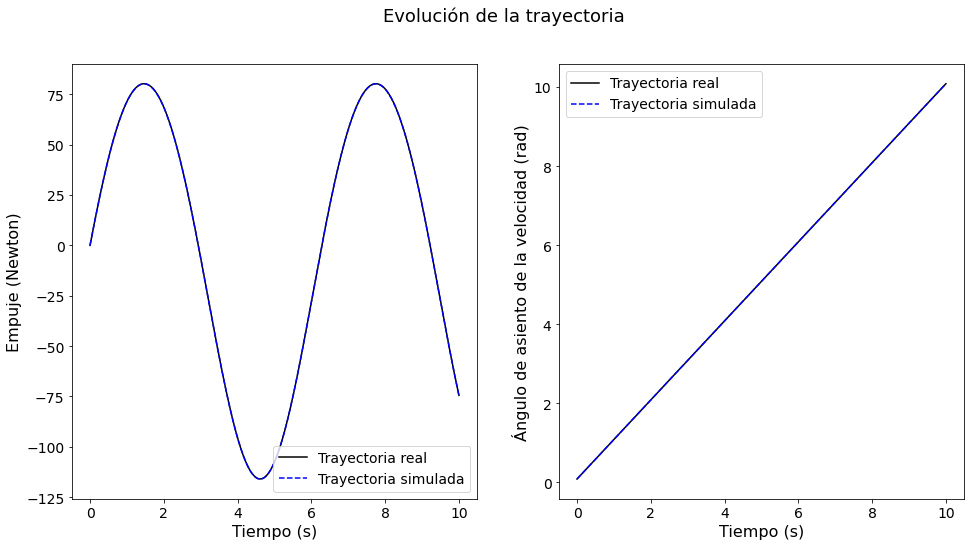

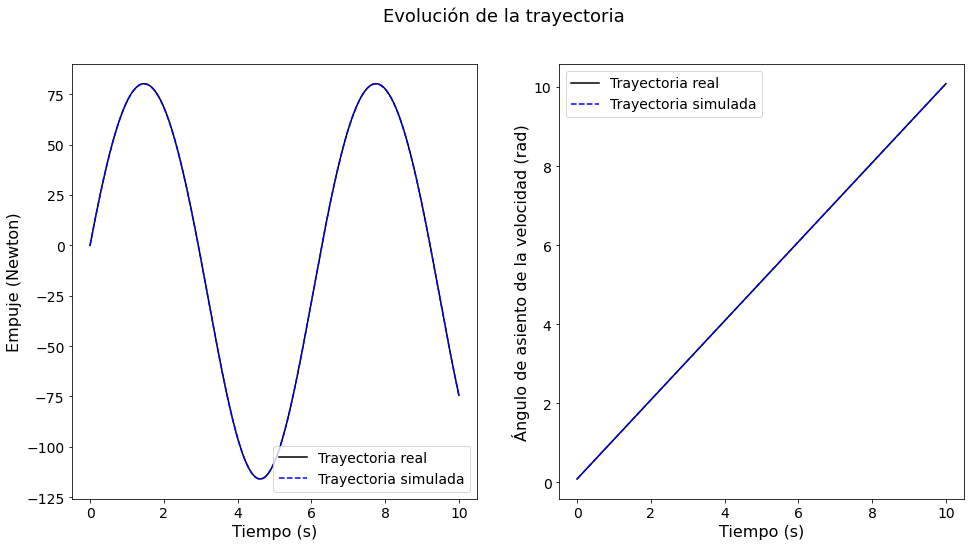

In [14]:
labs=['nada', 'initial_guess']
# con derivadas
n_trayectorias_test = [2, 5, 10, 15]
n_sims = 10#N_SIMS
x0 = [5, 5] #T0 y gamma0 en grados, de validacionn
deltat_train = t[1]-t[0]

t_val = np.arange(0, int(n*deltat_train), deltat_train)
len_traj = t_val.shape[0]
#assert n2 == len_traj

models = [None, utils.Model_params(deltat=deltat_train, initial_guess=initial(), lib=utils.custom_ecs_D2(), opt=1)]
errors = []
error = np.zeros((n_sims, len(n_trayectorias_test), n, 2))  

for mod, mod_index in zip(models, range(len(models))):
    error = np.zeros((n_sims, len(n_trayectorias_test), len_traj, 2))  
    for i in range(len(n_trayectorias_test)):
        for j in range(n_sims):
            mod_class = utils.Model()
            mod_class.eval(utils.casoD2, n_trayectorias_test[i], t, 
                                        [A6, A8, A9, A10], x0, print_model=True,
                                        adim=False, deltat_train=deltat_train, mod=mod, t_val=t_val, ders=True)
            error[j,i, :, :] = mod_class.error_trayec(t_val)
    errors.append(error)
    mod_class.plot_trayec(t_val, labs=['Empuje (Newton)', 'Ángulo de asiento de la velocidad (rad)'])
         


(10000, 2) (20000, 1)
['sin(2*T)', 'sin(2*gamma)', 'sin(T)', 'sin(gamma)', 'cos(T)', 'cos(gamma)', '1T', '1gamma']
(x0)' = -7.8022 sin(2*x1) + -1.5426 sin(x1) + 98.1008 cos(x1)
(x1)' = 0.7884 1x0 + 0.2116 1x1
(x0)' = -7.8023 sin(2*x1) + -1.5417 sin(x1) + 98.1008 cos(x1)
(x1)' = 0.9442 1x0 + 0.0558 1x1
(x0)' = -7.8022 sin(2*x1) + -1.5417 sin(x1) + 98.1009 cos(x1)
(x1)' = 0.8103 1x0 + 0.1897 1x1
(x0)' = -7.8025 sin(2*x1) + -1.5413 sin(x1) + 98.1004 cos(x1)
(x1)' = 0.6517 1x0 + 0.3483 1x1
(x0)' = -7.8030 sin(2*x1) + -1.5429 sin(x1) + 98.1013 cos(x1)
(x1)' = 0.0565 1x0 + 0.9435 1x1
(x0)' = -7.8030 sin(2*x1) + -1.5417 sin(x1) + 98.1018 cos(x1)
(x1)' = 0.9185 1x0 + 0.0815 1x1
(x0)' = -7.8023 sin(2*x1) + -1.5415 sin(x1) + 98.1020 cos(x1)
(x1)' = 0.7564 1x0 + 0.2436 1x1
(x0)' = -7.8027 sin(2*x1) + -1.5423 sin(x1) + 98.1015 cos(x1)
(x1)' = 1.4159 1x0 + -0.4159 1x1
(x0)' = -7.8023 sin(2*x1) + -1.5415 sin(x1) + 98.1015 cos(x1)
(x1)' = 1.0153 1x0 + -0.0153 1x1
(x0)' = -7.8024 sin(2*x1) + -1.5422 s

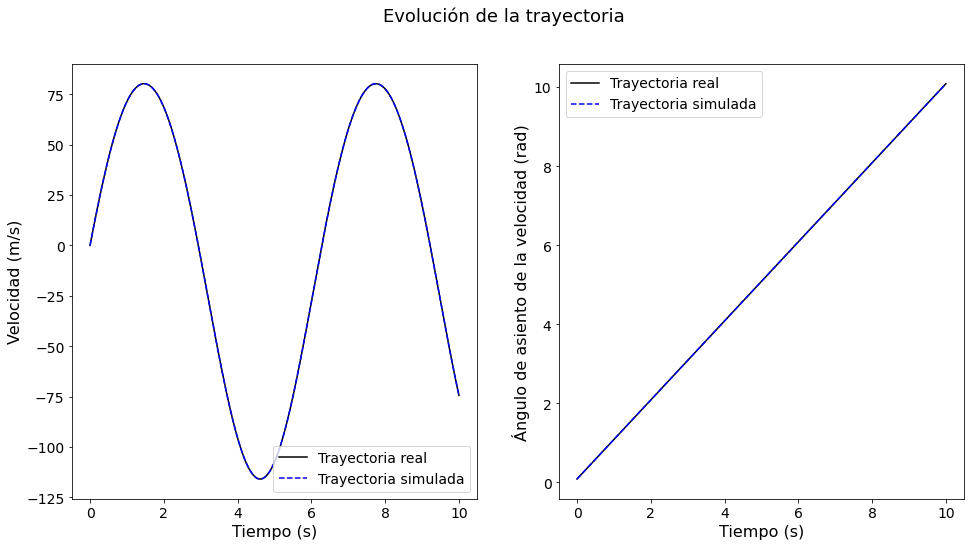

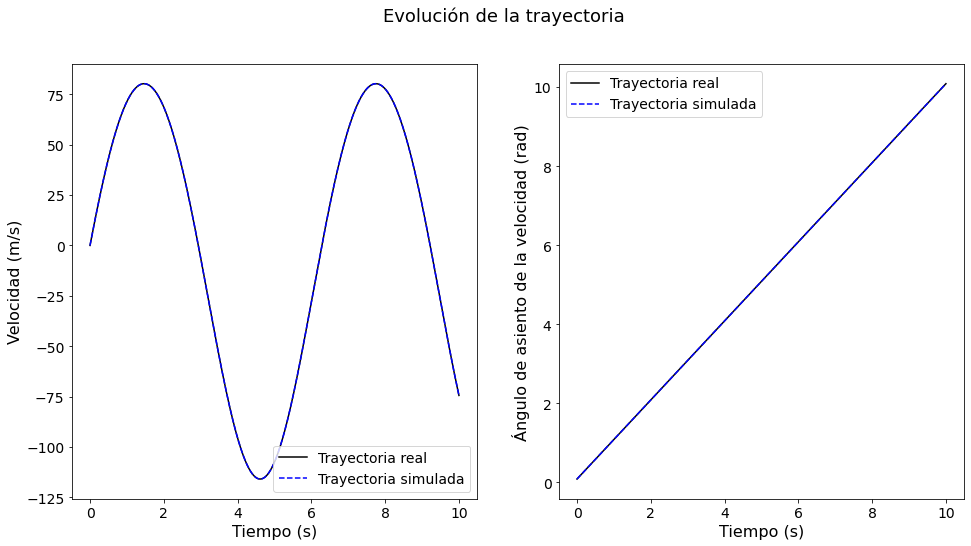

In [12]:
labs=['nada', 'initial_guess']
# igual que el anterior pero sin derivadas
n_trayectorias_test = [2, 5, 10, 15]
n_sims = 20#N_SIMS
x0 = [5, 5] #T0 y gamma0 en grados, de validacionn
deltat_train = t[1]-t[0]
n2 = 10**6
t_val = np.arange(0, int(n*deltat_train), deltat_train)
len_traj = t_val.shape[0]
#assert n2 == len_traj

models = [None, utils.Model_params(deltat=deltat_train, initial_guess=initial(), lib=utils.custom_ecs_D2(), opt=1)]
errors2 = []
error = np.zeros((n_sims, len(n_trayectorias_test), n, 2))  

for mod, mod_index in zip(models, range(len(models))):
    error = np.zeros((n_sims, len(n_trayectorias_test), len_traj, 2))  
    for i in range(len(n_trayectorias_test)):
        for j in range(n_sims):
            mod_class = utils.Model()
            mod_class.eval(utils.casoD2, n_trayectorias_test[i], t,
                                        [A6, A8, A9, A10], x0, print_model=True,
                                        adim=False, mod=mod, t_val=t_val)
            error[j,i, :, :] = mod_class.error_trayec(t_val)
         
    errors2.append(error)
    mod_class.plot_trayec(t_val)
         

2


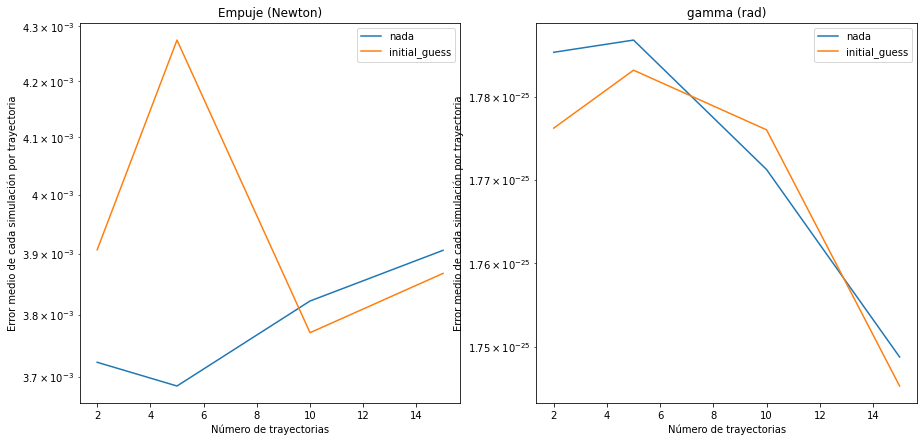

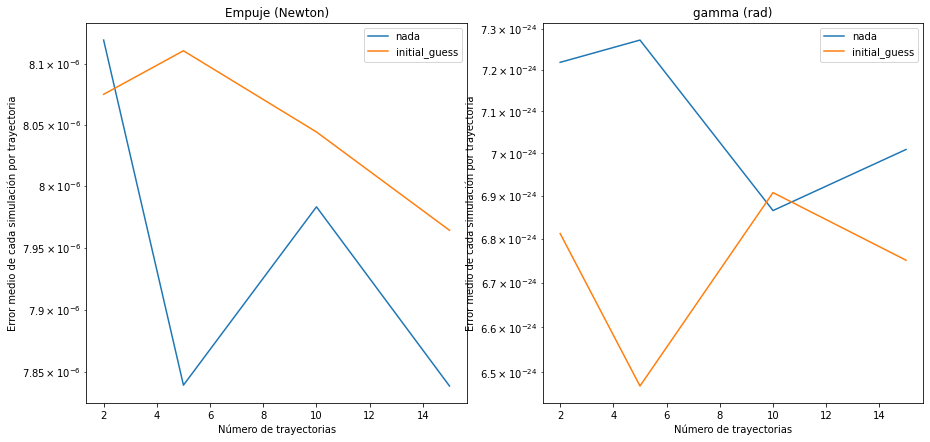

In [15]:
# Representar
print(len(errors))
plot_ntraj(n_trayectorias_test, errors)
plot_ntraj(n_trayectorias_test, errors2)

In [13]:
# error vs tiempo
n_trayectorias_test = [10, 20, 30]
n_sims = N_SIMS
len_traj = t.shape[0]
x0 = [5, 5] #T0 y gamma0 en grad, de validacionn
deltat_train = t[1]-t[0]
t_val = np.arange(0, int(n*deltat_train), deltat_train)


models = [None, utils.Model_params(deltat=deltat_train, initial_guess=initial(), lib=utils.custom_ecs_D2(), opt=1)]

error = np.zeros((n_sims, len(n_trayectorias_test), t.shape[0], 2)) 
errors3 = []
for mod in models:
    for i in range(len(n_trayectorias_test)):
        for j in range(n_sims):
            mod_class = utils.Model()
            mod_class.eval(utils.casoD2, n_trayectorias_test[i], t, [A6, A8, A9, A10], x0, 
                                        adim=False, t_val=t_val, mod=mod, ders=True)
            error[j,i, :, :] = mod_class.error_trayec(t_val)
    errors3.append(error)

(10000, 2) (20000, 1)
['sin(2*T)', 'sin(2*gamma)', 'sin(T)', 'sin(gamma)', 'cos(T)', 'cos(gamma)', '1T', '1gamma']


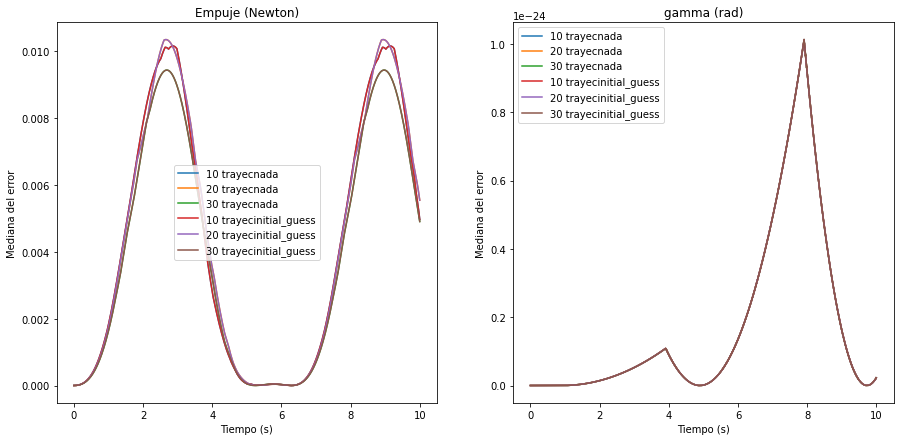

In [14]:
# Representar
plot_error_vs_tiempo(t, errors3, n_trayectorias_test)

In [14]:
#tiempos de validacion mas largos:

labs=['nada', 'initial_guess']

n_trayectorias_test = [5, 10, 15, 20]
tiempos_val = [10, 50, 100, 500, 1000]
n_sims = N_SIMS
x0 = [5, 5] #T0 y gamma0 en grados, de validacionn
deltat_train = t[1]-t[0]


models = [None]#, utils.Model_params(deltat=deltat_train, initial_guess=initial(), lib=utils.custom_ecs_D2(), opt=1)]
errors4 = []
error = np.zeros((n_sims, len(n_trayectorias_test), len(tiempos_val), 2))  

for mod, mod_index in zip(models, range(len(models))):
    print(labs[mod_index])  
    error = np.zeros((n_sims, len(n_trayectorias_test), len(tiempos_val), 2))  
    for i in range(len(n_trayectorias_test)):
        for z in range(len(tiempos_val)):
            t_val = np.arange(0, tiempos_val[z], deltat_train)
            for j in range(n_sims):
                mod_class = utils.Model()
                mod_class.eval(utils.casoD2, n_trayectorias_test[i], t, 
                                            [A6, A8, A9, A10], x0, ders=True,
                                            adim=False, deltat_train=deltat_train, mod=mod, t_val=t_val)
                error[j,i, z, :] = mod_class.error_trayec(t_val).mean(axis=0)
         
    errors4.append(error)


nada


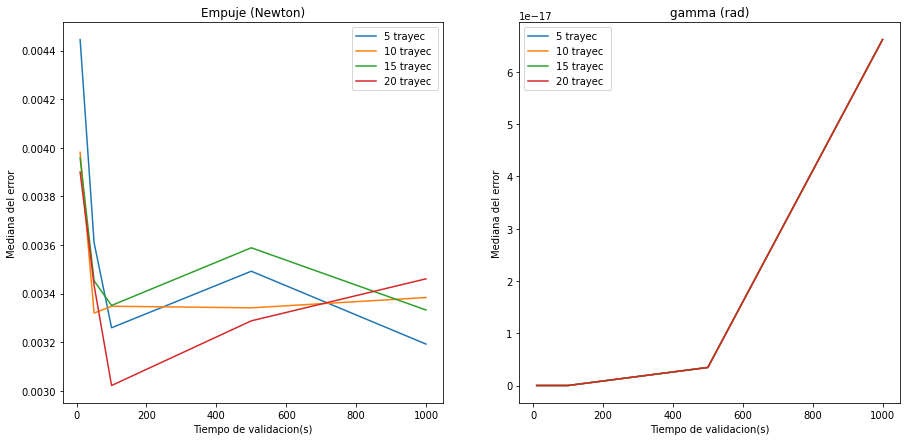

In [15]:
plot_error_vs_tiempo_val(tiempos_val, errors4, n_trayectorias_test, labs=[' '])

In [16]:
# pruebo con otras librerías: polinomica.

labs=['nada', 'initial_guess']
lib = ps.PolynomialLibrary(degree=2)
n_trayectorias_test = [2, 10, 15, 20]
n_sims = N_SIMS
x0 = [5, 5] #T0 y gamma0 en grados, de validacionn
deltat_train = t[1]-t[0]
t_val = np.arange(0, int(n*deltat_train), deltat_train)
len_traj = t_val.shape[0]

lib = ps.PolynomialLibrary(degree=2)
models = [#None, 
            utils.Model_params(deltat=deltat_train, lib=lib, opt=1)]
errors_pol = []
error = np.zeros((n_sims, len(n_trayectorias_test), n, 2))  

for mod, mod_index in zip(models, range(len(models))):
    print(labs[mod_index])  
    error = np.zeros((n_sims, len(n_trayectorias_test), len_traj, 2))  
    for i in range(len(n_trayectorias_test)):
        for j in range(n_sims):
            mod_class = utils.Model()
            mod_class.eval(utils.casoD2, n_trayectorias_test[i], t, 
                                        [A6, A8, A9, A10], x0, ders=True,
                                        adim=False, deltat_train=deltat_train, mod=mod, t_val=t_val)
            error[j,i, :, :] = mod_class.error_trayec(t_val)
         
    errors_pol.append(error)

nada


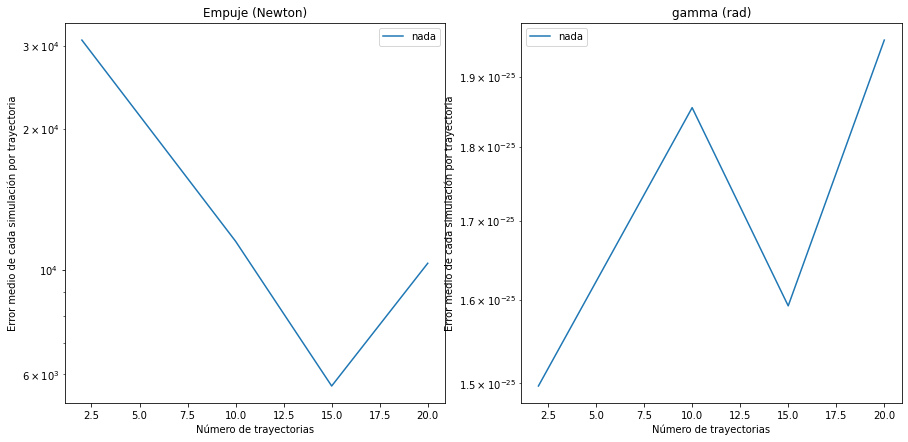

In [17]:
plot_ntraj(n_trayectorias_test, errors_pol)

In [22]:
# pruebo con otras librerías: fourier
labs=['nada', 'initial_guess']
lib = ps.FourierLibrary(n_frequencies=2)
n_trayectorias_test = [2, 10, 15, 20]
n_sims = N_SIMS
x0 = [5, 5] #T0 y gamma0 en grados, de validacionn
deltat_train = t[1]-t[0]

t_val = np.arange(0, int(n*deltat_train), deltat_train)
len_traj = t_val.shape[0]
#assert n2 == len_traj

models = [#None, 
            utils.Model_params(deltat=deltat_train, lib=lib, opt=1)]
errors_fou = []
error = np.zeros((n_sims, len(n_trayectorias_test), n, 2))  

for mod, mod_index in zip(models, range(len(models))):
    print(labs[mod_index])  
    error = np.zeros((n_sims, len(n_trayectorias_test), len_traj, 2))  
    for i in range(len(n_trayectorias_test)):
        for j in range(n_sims):
            mod_class = utils.Model()
            mod_class.eval(utils.casoD2, n_trayectorias_test[i], t, 
                                        [A6, A8, A9, A10], x0, ders=True,
                                        adim=False, deltat_train=deltat_train, mod=mod, t_val=t_val)
            error[j,i, :, :] = mod_class.error_trayec(t_val)

         
    errors_fou.append(error)

nada


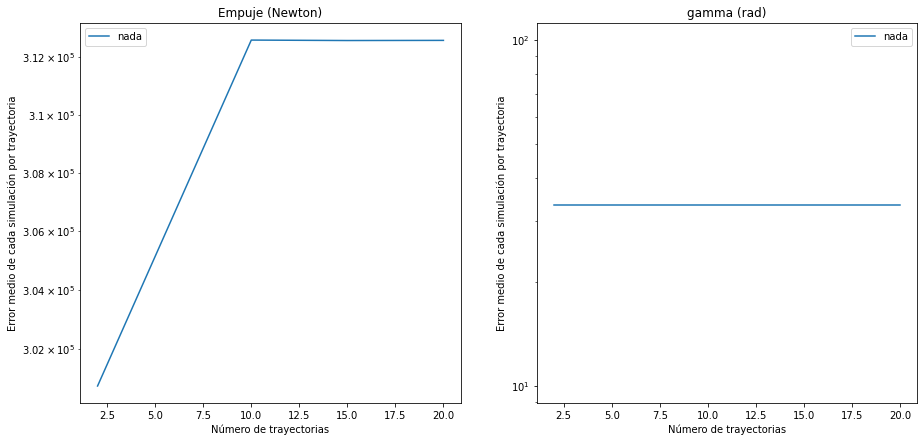

In [23]:
plot_ntraj(n_trayectorias_test, errors_fou)

In [34]:
# pruebo con otras librerías: polinomica + fourier. REEJECUTAR
labs=['nada', 'initial_guess']
lib = ps.PolynomialLibrary(degree=2) + ps.FourierLibrary(n_frequencies=2)
n_trayectorias_test = [10, 20, 35]
n_sims = 5#N_SIMS
x0 = [5, 5] #T0 y gamma0 en grados, de validacionn
deltat_train = t[1]-t[0]

t_val = np.arange(0, int(n*deltat_train), deltat_train)
len_traj = t_val.shape[0]
#assert n2 == len_traj

models = [#None,
            utils.Model_params(deltat=deltat_train, lib=lib, opt=1)]
errors_pf = []
error = np.zeros((n_sims, len(n_trayectorias_test), n, 2))  

for mod, mod_index in zip(models, range(len(models))):
    print(labs[mod_index])  
    error = np.zeros((n_sims, len(n_trayectorias_test), len_traj, 2))
    for i in range(len(n_trayectorias_test)):
        for j in range(n_sims):
            mod_class = utils.Model()
            mod_class.eval(utils.casoD2, n_trayectorias_test[i], t,
                                        [A6, A8, A9, A10], x0, ders=True,
                                        adim=False, deltat_train=deltat_train, mod=mod, t_val=t_val)
            error[j,i, :, :] = mod_class.error_trayec(t_val)
         
    errors_pf.append(error)

nada


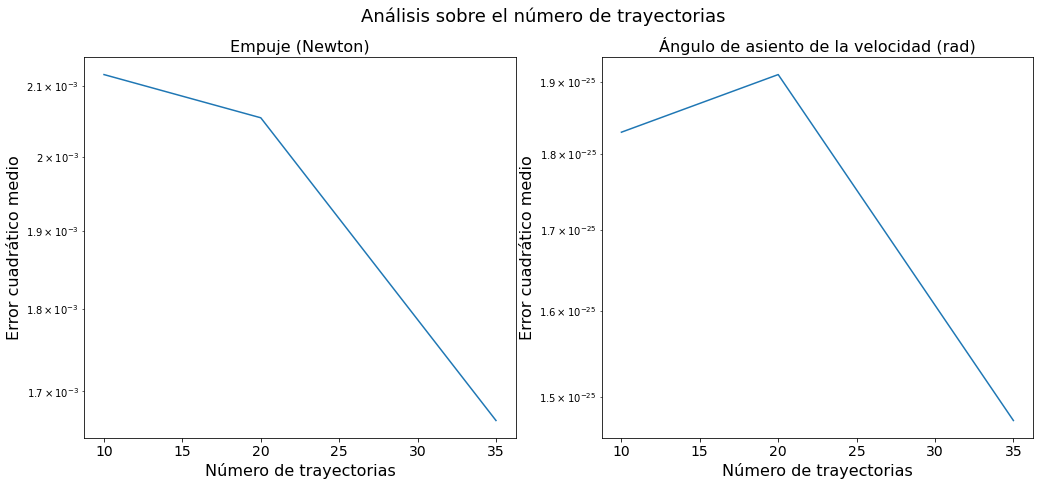

In [45]:
plot_ntraj(n_trayectorias_test, errors_pf)

In [25]:
# obtengo el error con ruido en las muestras, 
labs=['nada', 'initial_guess']

n_trayectorias_test = [10, 15, 20]
tiempos_val = [10, 50, 100, 500, 1000]
n_sims = 2#N_SIMS
x0 = [5, 5] #T0 y gamma0 en grados, de validacionn
deltat_train = t[1]-t[0]

models = [None, utils.Model_params(deltat=deltat_train, initial_guess=initial(), lib=utils.custom_ecs_D2(), opt=1)]
errors5 = []
error = np.zeros((n_sims, len(n_trayectorias_test), len(tiempos_val), 2))

for mod, mod_index in zip(models, range(len(models))):
    print(labs[mod_index])  
    error = np.zeros((n_sims, len(n_trayectorias_test), len(tiempos_val), 2)) 
    for i in range(len(n_trayectorias_test)):
        for z in range(len(tiempos_val)):
            t_val = np.arange(0, tiempos_val[z], deltat_train)
            for j in range(n_sims):
                mod_class = utils.Model()
                mod_class.eval(utils.casoD2, n_trayectorias_test[i], t,                                            
                                            [A6, A8, A9, A10], x0, ruido=0.001, ders=True,
                                            adim=False, deltat_train=deltat_train, mod=mod, t_val=t_val)
                error[j,i, z, :] = mod_class.error_trayec(t_val).mean(axis=0)
         
    errors5.append(error)



(10000, 2) (20000, 1)
['sin(2*T)', 'sin(2*gamma)', 'sin(T)', 'sin(gamma)', 'cos(T)', 'cos(gamma)', '1T', '1gamma']
nada
initial_guess


In [26]:
plot_error_vs_tiempo_val(tiempos_val, errors5, n_trayectorias_test)

NameError: name 'errors5' is not defined

In [13]:
# obtengo el error con ruido en las muestras 
labs=['nada', 'initial_guess'] 

n_trayectorias_test = [10, 15, 20, 30]
tiempos_val = [10, 50, 100, 500, 1000]
n_sims = N_SIMS
x0 = [5, 5] #T0 y gamma0 en grados, de validacionn
deltat_train = t[1]-t[0]


models = [None]#, utils.Model_params(deltat=deltat_train, initial_guess=initial(), lib=utils.custom_ecs_D2(), opt=1)]
errors6 = []
error = np.zeros((n_sims, len(n_trayectorias_test), len(tiempos_val), 2))  

for mod, mod_index in zip(models, range(len(models))):
    print(labs[mod_index])  
    error = np.zeros((n_sims, len(n_trayectorias_test), len(tiempos_val), 2))  
    for i in range(len(n_trayectorias_test)):
        for z in range(len(tiempos_val)):
            t_val = np.arange(0, tiempos_val[z], deltat_train)
            for j in range(n_sims):
                mod_class = utils.Model()
                mod_class.eval(utils.casoD2, n_trayectorias_test[i], 
                                            np.arange(0, int(n*deltat), deltat), 
                                            [A6, A8, A9, A10], x0, ruido=0.003, ders=True,
                                            adim=False, deltat_train=deltat_train, mod=mod, t_val=t_val)
                error[j,i, z, :] = mod_class.error_trayec(t_val).mean(axis=0)
         
    errors6.append(error)

nada


KeyboardInterrupt: 

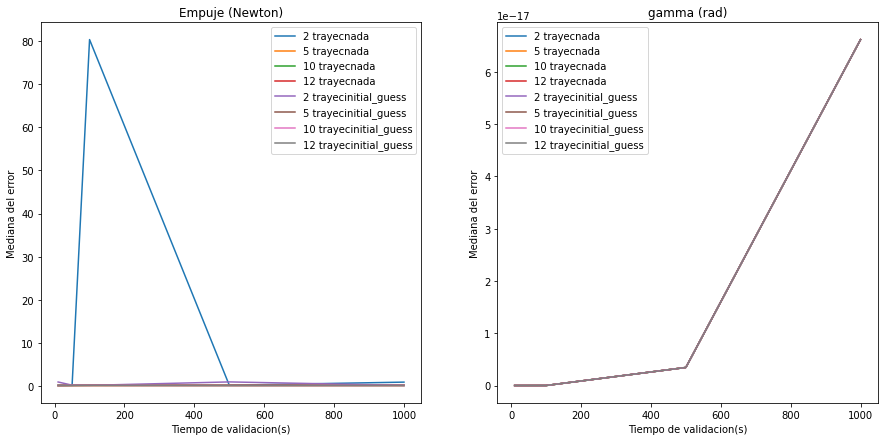

In [ ]:
# EJECUTAR
plot_error_vs_tiempo_val(tiempos_val, errors6, n_trayectorias_test, labs=[' '])

In [23]:
# error vs potencia de ruido en las muestras y en las derivadas

n_trayectorias_test = [1, 5, 15]
n_sims = 5#N_SIMS
x0 = [5, 5] #T0 y gamma0 en grados, de validacionn
pots_ruido = [1e-4, 1e-3, 1e-2, 0.1]
deltat_train = t[1]- t[0]
# t_train vs error en cada punto
error7 = np.zeros((n_sims, len(n_trayectorias_test), len(pots_ruido), 2))
for i in range(len(n_trayectorias_test)):
    print(n_trayectorias_test[i])
    for j in range(n_sims):
        for z in range(len(pots_ruido)):
            mod_class = utils.Model()
            mod_class.eval(utils.casoD2, n_trayectorias_test[i], 
                                            t, [A6, A8, A9, A10], x0, ders=True,
                                            adim=False, deltat_train=deltat_train, ruido=pots_ruido[z],
                                            ruido_dot=pots_ruido[z])
            error7[j,i,z, :] = mod_class.error_trayec(t).mean(axis=0)
            #print(pots_ruido[z])


1
5
15


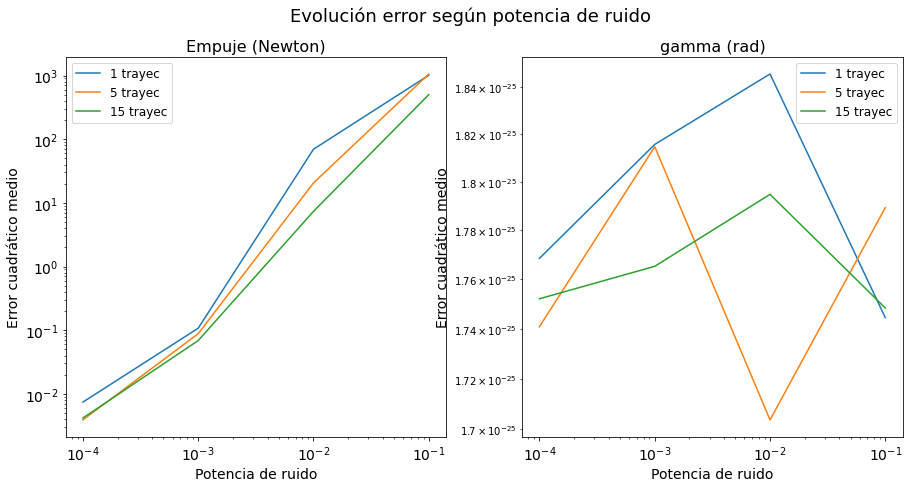

In [28]:
# Representar tiempo de val vs error con ruido
plot_error_vs_pot_ruido(error7, n_trayectorias_test, pots_ruido)

In [29]:
# error vs potencia de ruido en las muestras 
n_trayectorias_test = [10, 20, 30]
n_sims = 1#N_SIMS
x0 = [5, 5] #T0 y gamma0 en grados, de validacionn
pots_ruido = [1e-4, 1e-3, 1e-2, 0.1]
deltat_train = t[1]- t[0]
# t_train vs error en cada punto
error7_1 = np.zeros((n_sims, len(n_trayectorias_test), len(pots_ruido), 2))
for i in range(len(n_trayectorias_test)):
    print(n_trayectorias_test[i])
    for j in range(n_sims):
        for z in range(len(pots_ruido)):
            mod_class = utils.Model()
            mod_class.eval(utils.casoD2, n_trayectorias_test[i], 
                                            t, [A6, A8, A9, A10], x0, ders=True,
                                            adim=False, deltat_train=deltat_train, ruido=pots_ruido[z])
            error7_1[j,i,z, :] = mod_class.error_trayec(t).mean(axis=0)
            #print(pots_ruido[z])
# Representar tiempo de val vs error con ruido


10
20
30


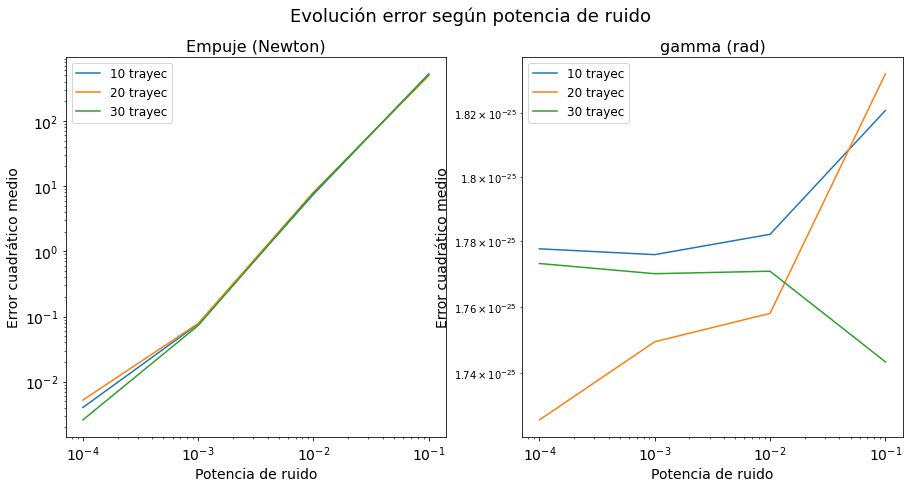

In [30]:
plot_error_vs_pot_ruido(error7_1, n_trayectorias_test, pots_ruido)

10
20
30


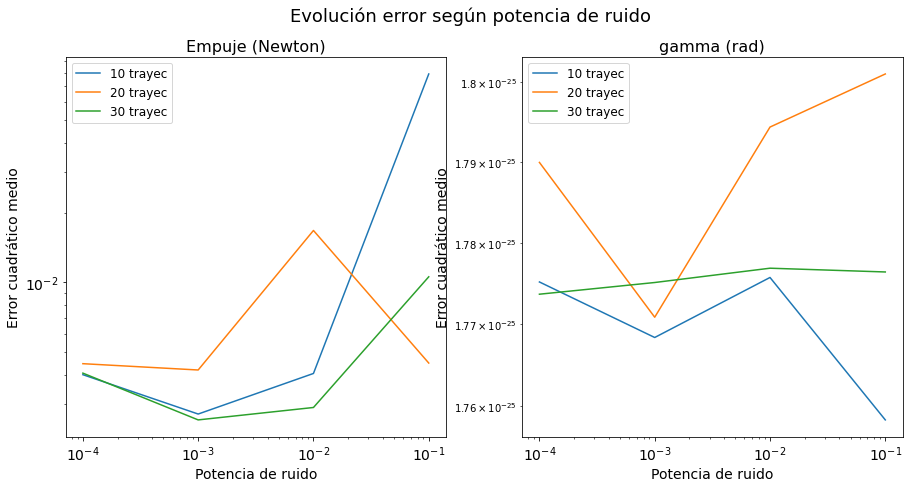

In [16]:
# error vs potencia de ruido en las derivadas 
n_trayectorias_test = [10, 20, 30]
n_sims = 1#N_SIMS
x0 = [5, 5] #T0 y gamma0 en grados, de validacionn
pots_ruido = [1e-4, 1e-3, 1e-2, 0.1]
deltat_train = t[1]- t[0]
# t_train vs error en cada punto
error7_2 = np.zeros((n_sims, len(n_trayectorias_test), len(pots_ruido), 2))
for i in range(len(n_trayectorias_test)):
    print(n_trayectorias_test[i])
    for j in range(n_sims):
        for z in range(len(pots_ruido)):
            mod_class = utils.Model()
            mod_class.eval(utils.casoD2, n_trayectorias_test[i], 
                                            t, [A6, A8, A9, A10], x0, ders=True,
                                            adim=False, deltat_train=deltat_train, ruido_dot=pots_ruido[z])
            error7_2[j,i,z, :] = mod_class.error_trayec(t).mean(axis=0)
            #print(pots_ruido[z])
# Representar tiempo de val vs error con ruido
plot_error_vs_pot_ruido(error7_2, n_trayectorias_test, pots_ruido)

In [ ]:
# representar precision vs t de train y error medio
n_trayectorias_test = [5, 10, 15]
n_sims = N_SIMS
x0 = [5, 5] #T0 y gamma0 en grados, de validacionn
trayec = 10
tiempos_train = [10, 50, 100, 500, 1000]
muestras = [10**4, 10**5, 10**6]
deltat_train = t[1]-t[0]
# t_train vs error en cada punto
error9 = np.zeros((n_sims, len(muestras), len(tiempos_train), 2))
for i in range(len(muestras)):
    for j in range(n_sims):
        for z in range(len(tiempos_train)):
            t_train = np.arange(0, tiempos_train[z], deltat_train)
            error9[j,i,z, :] = utils.eval(utils.casoD2, trayec, 
                                            t_train, [A6, A8, A9, A10], x0, ders=True,
                                            adim=False, deltat_train=deltat_train).mean(axis=0)
            


In [ ]:
plot_precision_tiempo(error9, muestras, tiempos_train)

In [1]:
def real_coefs_mat(real_coefs):
    features, data, list_names = initial_vars(lib=utils.custom_ecs_D2())
    mat = np.zeros((data[0].shape[1], features))

    mat[0, list_names.index('sin(2*gamma)')] = real_coefs[0]
    mat[0, list_names.index('sin(gamma)')] = real_coefs[1]
    mat[0, list_names.index('cos(gamma)')] = real_coefs[2]
    mat[1, list_names.index('1gamma')] = real_coefs[3]

    return mat

In [2]:
# error en los coeficientes según el número de trayectorias:
n_trayectorias_test = [2, 5, 10, 12]
n_sims = N_SIMS
x0 = [3, 5] #v0 y gamma0 en grados, de validacionn
deltat_train = t[1]-t[0]

real_coefs = np.array([-A8, -A9, A10, A6])
mat_real_coefs = real_coefs_mat(real_coefs)

models = [None, utils.Model_params(deltat=deltat_train, initial_guess=initial(), lib=utils.custom_ecs_D2(), opt=1)]
errors10 = []
errors10_1 = []
error = np.zeros((n_sims, len(n_trayectorias_test)))  
error2 = np.zeros((n_sims, len(n_trayectorias_test)))

for mod, mod_index in zip(models, range(len(models))):
    for i in range(len(n_trayectorias_test)):
        for j in range(n_sims):
            mod_class = utils.Model()
            mod_class.eval(utils.casoD2, n_trayectorias_test[i], t,
                                        [A6, A8, A9, A10], x0, 
                                        adim=False, deltat_train=deltat_train, mod=mod, print_model=False)
            #print(mod_class.model_sindy.coefficients().shape)
            #print(mat_real_coefs.shape)
            
            error[j, i] = np.mean(mod_class.error_coefs(mat_real_coefs)**2)
            error2[j, i] = np.mean(mod_class.error_trayec(t))

    errors10.append(error)
    errors10_1.append(error2)


NameError: name 'N_SIMS' is not defined

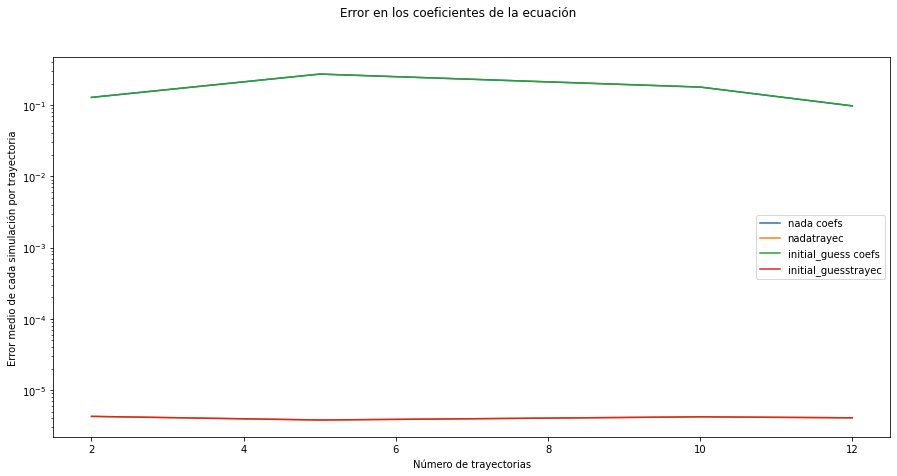

In [24]:
fig= plt.figure(figsize=(15, 7))
fig.suptitle('Error en los coeficientes de la ecuación')
labs = ['nada', 'initial_guess']
for j in range(len(errors10)):
    plt.semilogy(n_trayectorias_test, np.median(errors10[j], axis=0), label=labs[j]+' coefs')
    plt.semilogy(n_trayectorias_test, np.median(errors10_1[j], axis=0), label=labs[j] + 'trayec')
    plt.xlabel('Número de trayectorias')
    plt.ylabel('Error medio de cada simulación por trayectoria')
    plt.legend()

In [17]:
# error en los coeficientes según el número de trayectorias:
n_trayectorias_test = [5, 10, 25]
pots_ruido = [1e-4, 1e-3, 1e-2, 1e-1]
n_sims = N_SIMS
x0 = [3, 5] #v0 y gamma0 en grados, de validacionn
deltat_train = t[1]-t[0]

real_coefs = np.array([-A8, -A9, A10, A6])
mat_real_coefs = real_coefs_mat(real_coefs)

error11 = np.zeros((n_sims, len(n_trayectorias_test), len(pots_ruido)))


for i in range(len(n_trayectorias_test)):
    for j in range(n_sims):
        for z in range(len(pots_ruido)):
            mod_class = utils.Model()
            mod_class.eval(utils.casoD2, n_trayectorias_test[i], t,
                                            [A6, A8, A9, A10], x0, 
                                            adim=False, deltat_train=deltat_train, ruido=pots_ruido[z], 
                                            print_model=False)
            
            error11[j, i, z] = np.mean(mod_class.error_coefs(mat_real_coefs)**2)



(10000, 2) (20000, 1)
['sin(2*T)', 'sin(2*gamma)', 'sin(T)', 'sin(gamma)', 'cos(T)', 'cos(gamma)', '1T', '1gamma']


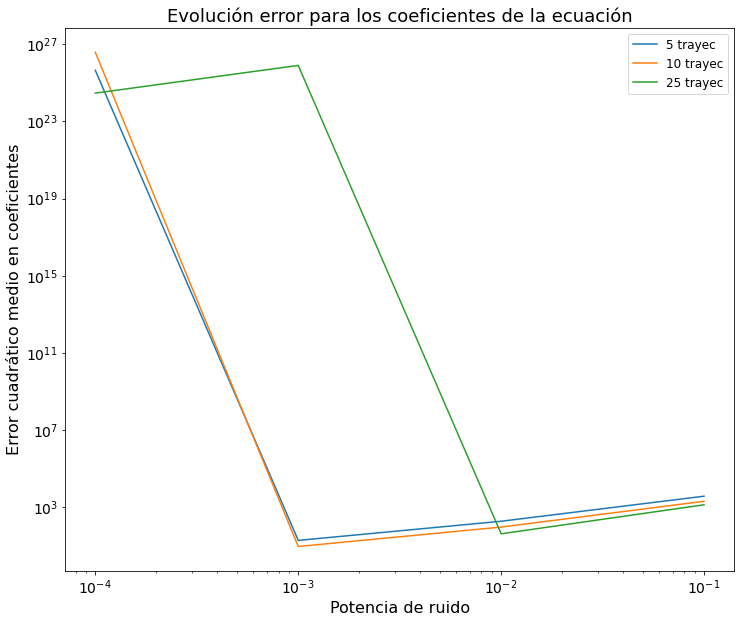

In [18]:
plt.figure(figsize=(12,10))
plt.title("Evolución error para los coeficientes de la ecuación", fontsize=18)
plt.xlabel('Potencia de ruido', fontsize=16)
plt.ylabel('Error cuadrático medio en coeficientes', fontsize=16)
error11_1 = np.median(error11, axis=0)
for trayec, i in zip(n_trayectorias_test, range(len(n_trayectorias_test))):
    plt.loglog(pots_ruido, error11_1[i, :], label=str(trayec)+ ' trayec')
    
plt.xticks(fontsize=14) 
plt.yticks(fontsize=14)
plt.legend(fontsize=12)